<a href="https://colab.research.google.com/github/hassen8/emotion_recognition_bias_auditing/blob/master/notebooks/EmotiEffLib_GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

from google.colab import drive
drive.mount("/content/drive")

/bin/bash: line 1: nvidia-smi: command not found
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!git config --global user.email "luwammajor5@gmail.com"
!git config --global user.name "LuwamMKefali"

In [11]:
!git clone https://github.com/hassen8/emotion_recognition_bias_auditing.git

Cloning into 'emotion_recognition_bias_auditing'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 46 (delta 15), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 1.50 MiB | 11.66 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [12]:
%cd emotion_recognition_bias_auditing

/content/emotion_recognition_bias_auditing/emotion_recognition_bias_auditing


In [7]:
from getpass import getpass
TOKEN = getpass("GitHub token: ")

GitHub token: ··········


In [13]:
!git remote set-url origin https://{TOKEN}@github.com/hassen8/emotion_recognition_bias_auditing.git

In [14]:
!git push

Everything up-to-date


In [15]:
!git pull

Already up to date.


In [9]:
!git remote set-url origin https://github.com/hassen8/emotion_recognition_bias_auditing.git


# Package installations

In [97]:
!pip -q install emotiefflib[torch] opencv-python tqdm pandas matplotlib
!pip -q install facenet-pytorch==2.5.3 pillow==10.2.0
!pip -q install grad-cam

In [98]:
!pip -q install torchvision

In [96]:
# Silent extraction to avoid the long dataset loading
!unzip -oq /content/drive/MyDrive/Image/aligned.zip -d /content/emotion_recognition_bias_auditing/aligned

In [18]:
!cp /content/drive/MyDrive/EmoLabel/list_patition_label.txt .

# Imports + paths

In [72]:
from pathlib import Path
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

ALIGNED_DIR = Path("/content/emotion_recognition_bias_auditing/aligned")
LABEL_FILE  = Path("/content/emotion_recognition_bias_auditing/list_patition_label.txt")

print("Aligned images (sample):", len(list(ALIGNED_DIR.glob("*.jpg"))))


Aligned images (sample): 15339


## Load RAD-DB labels

In [74]:
# RAF-DB 7-class mapping
RAF_7 = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral",
}
def load_raf_labels(label_path: Path) -> pd.DataFrame:
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            fname = parts[0]
            lab = int(parts[1])       # 1-7
            rows.append({"fname": fname, "gt_label": lab})
    df = pd.DataFrame(rows)
    df["gt_emotion"] = df["gt_label"].map(RAF_7)
    return df

df_labels = load_raf_labels(LABEL_FILE)
print("Label rows:", len(df_labels))
df_labels.head()

Label rows: 15339


,fname,gt_label,gt_emotion
0,train_00001.jpg,5,sad
1,train_00002.jpg,5,sad
2,train_00003.jpg,4,happy
3,train_00004.jpg,4,happy
4,train_00005.jpg,5,sad


## Map label files names

In [75]:
df_labels["gt_emotion"] = df_labels["gt_label"].map(RAF_7)

def label_to_aligned_path(fname_from_labels: str) -> Path:
    stem = Path(fname_from_labels).stem  # train_00001
    return ALIGNED_DIR / f"{stem}_aligned.jpg"

df_labels["aligned_path"] = df_labels["fname"].apply(label_to_aligned_path)

df = df_labels[df_labels["aligned_path"].apply(lambda p: p.exists())].copy().reset_index(drop=True)

print("Total labels:", len(df_labels))
print("Matched aligned images:", len(df))
print("Example aligned file:", df.iloc[0]["aligned_path"])
df.head()


Total labels: 15339
Matched aligned images: 15339
Example aligned file: /content/emotion_recognition_bias_auditing/aligned/train_00001_aligned.jpg


,fname,gt_label,gt_emotion,aligned_path
0,train_00001.jpg,5,sad,/content/emotion_recognition_bias_auditing/ali...
1,train_00002.jpg,5,sad,/content/emotion_recognition_bias_auditing/ali...
2,train_00003.jpg,4,happy,/content/emotion_recognition_bias_auditing/ali...
3,train_00004.jpg,4,happy,/content/emotion_recognition_bias_auditing/ali...
4,train_00005.jpg,5,sad,/content/emotion_recognition_bias_auditing/ali...


In [76]:
import re

def infer_split_from_name(name: str):
    n = name.lower()
    if n.startswith("train_"):
        return "train"
    if n.startswith("test_"):
        return "test"
    return "unknown"

def extract_id_from_aligned_name(name: str):
    # train_00001_aligned.jpg -> 00001
    # test_2693_aligned.jpg  -> 2693
    m = re.match(r"^(train|test)_(\d+)_aligned\.jpg$", name.lower())
    return m.group(2) if m else None

paths = sorted(ALIGNED_DIR.glob("*_aligned.jpg"))
df_all = pd.DataFrame({"aligned_path": paths})
df_all["aligned_name"] = df_all["aligned_path"].apply(lambda p: p.name)
df_all["split"] = df_all["aligned_name"].apply(infer_split_from_name)
df_all["img_id"] = df_all["aligned_name"].apply(extract_id_from_aligned_name)

print(df_all["split"].value_counts(dropna=False))
df_all.head()

split
train    12271
test      3068
Name: count, dtype: int64


,aligned_path,aligned_name,split,img_id
0,/content/emotion_recognition_bias_auditing/ali...,test_0001_aligned.jpg,test,0001
1,/content/emotion_recognition_bias_auditing/ali...,test_0002_aligned.jpg,test,0002
2,/content/emotion_recognition_bias_auditing/ali...,test_0003_aligned.jpg,test,0003
3,/content/emotion_recognition_bias_auditing/ali...,test_0004_aligned.jpg,test,0004
4,/content/emotion_recognition_bias_auditing/ali...,test_0005_aligned.jpg,test,0005


In [77]:
def extract_id_from_label_fname(label_fname: str):
    # train_00001.jpg -> 00001
    # test_00001.jpg  -> 00001
    # keeps leading zeros as string
    stem = Path(label_fname).stem.lower()   # "train_00001"
    m = re.match(r"^(train|test)_(\d+)$", stem)
    return m.group(2) if m else None

df_labels["img_id"] = df_labels["fname"].apply(extract_id_from_label_fname)
df_labels["split_label"] = df_labels["fname"].apply(lambda s: "train" if str(s).lower().startswith("train_") else ("test" if str(s).lower().startswith("test_") else "unknown"))

print(df_labels["split_label"].value_counts(dropna=False))
df_labels.head()

split_label
train    12271
test      3068
Name: count, dtype: int64


,fname,gt_label,gt_emotion,aligned_path,img_id,split_label
0,train_00001.jpg,5,sad,/content/emotion_recognition_bias_auditing/ali...,00001,train
1,train_00002.jpg,5,sad,/content/emotion_recognition_bias_auditing/ali...,00002,train
2,train_00003.jpg,4,happy,/content/emotion_recognition_bias_auditing/ali...,00003,train
3,train_00004.jpg,4,happy,/content/emotion_recognition_bias_auditing/ali...,00004,train
4,train_00005.jpg,5,sad,/content/emotion_recognition_bias_auditing/ali...,00005,train


In [78]:
df_merged = df_all.merge(
    df_labels[["img_id", "gt_label", "gt_emotion", "split_label"]],
    left_on=["img_id", "split"],
    right_on=["img_id", "split_label"],
    how="left"
)

print("Missing gt_emotion rate:", df_merged["gt_emotion"].isna().mean())
print(df_merged["split"].value_counts(dropna=False))
df_merged.head()


Missing gt_emotion rate: 0.0
split
train    12271
test      3068
Name: count, dtype: int64


,aligned_path,aligned_name,split,img_id,gt_label,gt_emotion,split_label
0,/content/emotion_recognition_bias_auditing/ali...,test_0001_aligned.jpg,test,0001,5,sad,test
1,/content/emotion_recognition_bias_auditing/ali...,test_0002_aligned.jpg,test,0002,1,surprise,test
2,/content/emotion_recognition_bias_auditing/ali...,test_0003_aligned.jpg,test,0003,4,happy,test
3,/content/emotion_recognition_bias_auditing/ali...,test_0004_aligned.jpg,test,0004,1,surprise,test
4,/content/emotion_recognition_bias_auditing/ali...,test_0005_aligned.jpg,test,0005,5,sad,test


In [79]:
df = df_merged.dropna(subset=["gt_emotion"]).copy().reset_index(drop=True)
df["fname"] = df["aligned_name"]  # use aligned filename as fname for saving overlays etc.

print("Final df size:", len(df))
print(df["split"].value_counts())
df.head()


Final df size: 15339
split
train    12271
test      3068
Name: count, dtype: int64


,aligned_path,aligned_name,split,img_id,gt_label,gt_emotion,split_label,fname
0,/content/emotion_recognition_bias_auditing/ali...,test_0001_aligned.jpg,test,0001,5,sad,test,test_0001_aligned.jpg
1,/content/emotion_recognition_bias_auditing/ali...,test_0002_aligned.jpg,test,0002,1,surprise,test,test_0002_aligned.jpg
2,/content/emotion_recognition_bias_auditing/ali...,test_0003_aligned.jpg,test,0003,4,happy,test,test_0003_aligned.jpg
3,/content/emotion_recognition_bias_auditing/ali...,test_0004_aligned.jpg,test,0004,1,surprise,test,test_0004_aligned.jpg
4,/content/emotion_recognition_bias_auditing/ali...,test_0005_aligned.jpg,test,0005,5,sad,test,test_0005_aligned.jpg


## Load EmotiEffLib

In [80]:
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

print("Available EmotiEffLib models:\n", get_model_list())

MODEL_NAME = "enet_b0_8_best_vgaf"
emotion_recognizer = EmotiEffLibRecognizer(engine="torch", model_name=MODEL_NAME, device=device)

print("Loaded model:", MODEL_NAME)


device: cpu
Available EmotiEffLib models:
 ['enet_b0_8_best_vgaf', 'enet_b0_8_best_afew', 'enet_b2_8', 'enet_b0_8_va_mtl', 'enet_b2_7', 'mbf_va_mtl', 'mobilevit_va_mtl']
Loaded model: enet_b0_8_best_vgaf


## Unrawp torck model + pick Grad-Cam target layer

In [84]:
import torch.nn as nn

def unwrap_torch_model(recognizer):
    for attr in ["model", "net", "backbone", "_model"]:
        if hasattr(recognizer, attr):
            m = getattr(recognizer, attr)
            if isinstance(m, nn.Module):
                return m
    for _, v in recognizer.__dict__.items():
        if isinstance(v, nn.Module):
            return v
    raise RuntimeError("Could not find a torch.nn.Module inside EmotiEffLibRecognizer.")

torch_model = unwrap_torch_model(emotion_recognizer).to(device).eval()
print("Torch model type:", type(torch_model))

def find_last_conv_layer(model):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d layer found for Grad-CAM.")
    return last

target_layer = find_last_conv_layer(torch_model)
print("Grad-CAM target layer:", target_layer)


Torch model type: <class 'timm.models.efficientnet.EfficientNet'>
Grad-CAM target layer: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Utilities: image reading + prediction

In [85]:
def read_rgb(path: Path):
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        return None
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def predict_emotieff(face_rgb_uint8):
    # EmotiEffLib expects list of RGB uint8 (H,W,3)
    emotions, logits = emotion_recognizer.predict_emotions([face_rgb_uint8], logits=True)
    return emotions[0], logits[0]


# Grad-CAM setup + preprocess

In [86]:
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def to_model_tensor(face_rgb_uint8, image_size=224):
    tfm = T.Compose([
        T.ToPILImage(),
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std =[0.229, 0.224, 0.225]),
    ])
    x = tfm(face_rgb_uint8).unsqueeze(0).to(device)
    return x

def run_gradcam(face_rgb_uint8, image_size=224):
    x = to_model_tensor(face_rgb_uint8, image_size=image_size)

    with torch.no_grad():
        out = torch_model(x)
        if out.ndim == 1:
            out = out.unsqueeze(0)
        cls_idx = int(out.argmax(dim=1).item())

    cam = GradCAM(model=torch_model, target_layers=[target_layer])
    cam_map = cam(input_tensor=x, targets=[ClassifierOutputTarget(cls_idx)])[0]  # (H,W), nonnegative

    # Make overlay in RGB space
    face_rs = cv2.resize(face_rgb_uint8, (cam_map.shape[1], cam_map.shape[0]))
    face_float = face_rs.astype(np.float32) / 255.0
    cam_vis = show_cam_on_image(face_float, cam_map, use_rgb=True)

    return cls_idx, cam_map, face_rs, cam_vis


## single-image test

Testing sample: /content/emotion_recognition_bias_auditing/aligned/test_0001_aligned.jpg
GT: sad
EmotiEffLib pred: Sadness (conf=0.990)
Torch class idx: 180


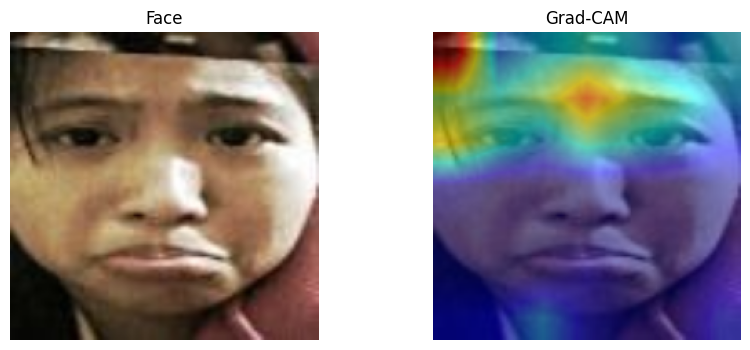

In [87]:
sample_path = df.iloc[0]["aligned_path"]
print("Testing sample:", sample_path)

face = read_rgb(sample_path)
assert face is not None, f"Could not read image: {sample_path}"

pred_label, pred_logits = predict_emotieff(face)
probs = torch.softmax(torch.tensor(pred_logits), dim=0).cpu().numpy()
pred_conf = float(probs[np.argmax(probs)])

cls_idx, cam_map, face_rs, cam_vis = run_gradcam(face)

print("GT:", df.iloc[0]["gt_emotion"])
print("EmotiEffLib pred:", pred_label, f"(conf={pred_conf:.3f})")
print("Torch class idx:", cls_idx)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(face_rs); plt.axis("off"); plt.title("Face")
plt.subplot(1,2,2); plt.imshow(cam_vis); plt.axis("off"); plt.title("Grad-CAM")
plt.show()


# Regional Fraction (eyes/nose/mouth/other)

In [88]:
def get_face_regions(h, w):
    """
    Approximate regions in aligned face crop using proportional bands.
    Returns dict region -> (x1,y1,x2,y2)
    """
    # Eyes: upper-middle band
    eye_y1 = int(0.20 * h)
    eye_y2 = int(0.42 * h)
    eye_x1 = int(0.18 * w)
    eye_x2 = int(0.82 * w)

    # Mouth: lower band
    mouth_y1 = int(0.62 * h)
    mouth_y2 = int(0.90 * h)
    mouth_x1 = int(0.22 * w)
    mouth_x2 = int(0.78 * w)

    # Nose/center: mid box
    nose_y1 = int(0.40 * h)
    nose_y2 = int(0.70 * h)
    nose_x1 = int(0.35 * w)
    nose_x2 = int(0.65 * w)

    return {
        "eyes":  (eye_x1,  eye_y1,  eye_x2,  eye_y2),
        "nose":  (nose_x1, nose_y1, nose_x2, nose_y2),
        "mouth": (mouth_x1, mouth_y1, mouth_x2, mouth_y2),
    }

def compute_region_fractions(face_rgb_uint8, cam_map):
    """
    cam_map is (h_cam, w_cam). Resize to face size, sum CAM mass in regions, return fractions.
    """
    H, W, _ = face_rgb_uint8.shape

    # Resize cam to face resolution
    cam_rs = cv2.resize(cam_map.astype(np.float32), (W, H), interpolation=cv2.INTER_LINEAR)
    cam_rs = np.clip(cam_rs, 0, None)

    total = float(cam_rs.sum())
    if total <= 1e-12:
        return {"eyes": 0.0, "nose": 0.0, "mouth": 0.0, "other": 1.0}

    regions = get_face_regions(H, W)

    region_sums = {}
    for name, (x1, y1, x2, y2) in regions.items():
        patch = cam_rs[y1:y2, x1:x2]
        region_sums[name] = float(patch.sum())

    known = sum(region_sums.values())
    other = max(total - known, 0.0)

    fracs = {k: v / total for k, v in region_sums.items()}
    fracs["other"] = other / total
    return fracs


# Barch run + save overlays + CSV

In [27]:
!pip install tqdm

In [89]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image

OUT_DIR = Path("/content/emotiefflib_gradcam_outputs")
(OUT_DIR / "overlays").mkdir(parents=True, exist_ok=True)

def run_emotieff_on_df(df, n=None):
    """
    df must contain:
      - fname
      - aligned_path
      - gt_emotion
      - split
    """
    rows_pred, rows_region, rows_fail = [], [], []
    df = df.reset_index(drop=True)

    N = len(df) if n is None else min(int(n), len(df))

    for i in tqdm(range(N)):
        fname = str(df.loc[i, "fname"])
        img_path = Path(df.loc[i, "aligned_path"])
        gt_emotion = str(df.loc[i, "gt_emotion"])
        split = str(df.loc[i, "split"])

        face = read_rgb(img_path)
        if face is None:
            rows_fail.append({"i": i, "fname": fname, "aligned_path": str(img_path), "status": "read_fail"})
            rows_pred.append({
                "i": i, "fname": fname, "aligned_path": str(img_path),
                "split": split, "gt_emotion": gt_emotion,
                "pred_emotion": None, "pred_conf": None,
                "overlay_path": None, "status": "read_fail"
            })
            continue

        # Prediction
        try:
            pred_label, pred_logits = predict_emotieff(face)
            probs = torch.softmax(torch.tensor(pred_logits), dim=0).cpu().numpy()
            pred_conf = float(probs[np.argmax(probs)])
        except Exception as e:
            rows_fail.append({"i": i, "fname": fname, "aligned_path": str(img_path), "status": f"predict_fail: {e}"})
            rows_pred.append({
                "i": i, "fname": fname, "aligned_path": str(img_path),
                "split": split, "gt_emotion": gt_emotion,
                "pred_emotion": None, "pred_conf": None,
                "overlay_path": None, "status": "predict_fail"
            })
            continue

        # Grad-CAM
        try:
            cls_idx, cam_map, face_rs, cam_vis = run_gradcam(face)
        except Exception as e:
            rows_fail.append({"i": i, "fname": fname, "aligned_path": str(img_path), "status": f"gradcam_fail: {e}"})
            rows_pred.append({
                "i": i, "fname": fname, "aligned_path": str(img_path),
                "split": split, "gt_emotion": gt_emotion,
                "pred_emotion": str(pred_label), "pred_conf": pred_conf,
                "overlay_path": None, "status": "gradcam_fail"
            })
            continue

        # Region fractions
        fracs = compute_region_fractions(face_rs, cam_map)

        # Save overlay
        safe_gt = gt_emotion.replace(" ", "_")
        safe_pred = str(pred_label).replace(" ", "_")
        save_name = f"{Path(fname).stem}_gt-{safe_gt}_pred-{safe_pred}.png"
        save_path = OUT_DIR / "overlays" / save_name
        Image.fromarray(cam_vis).save(save_path)

        rows_pred.append({
            "i": i,
            "fname": fname,
            "aligned_path": str(img_path),
            "split": split,
            "gt_emotion": gt_emotion,
            "pred_emotion": str(pred_label),
            "pred_conf": pred_conf,
            "overlay_path": str(save_path),
            "status": "ok",
        })

        rows_region.append({
            "i": i,
            "fname": fname,
            "split": split,
            "gt_emotion": gt_emotion,
            "pred_emotion": str(pred_label),
            "pred_conf": pred_conf,
            **fracs
        })

    df_pred = pd.DataFrame(rows_pred)
    df_region = pd.DataFrame(rows_region)
    df_fail = pd.DataFrame(rows_fail)

    df_pred.to_csv(OUT_DIR / "predictions.csv", index=False)
    df_region.to_csv(OUT_DIR / "region_fractions.csv", index=False)
    if len(df_fail) > 0:
        df_fail.to_csv(OUT_DIR / "failures.csv", index=False)

    return df_pred, df_region, df_fail


In [91]:
df_train = df[df["split"]=="train"].sample(10, random_state=0, replace=False) if (df["split"]=="train").sum() >= 200 else df[df["split"]=="train"]
df_test  = df[df["split"]=="test"].sample(10, random_state=0, replace=False) if (df["split"]=="test").sum() >= 200 else df[df["split"]=="test"]
df_run = pd.concat([df_train, df_test], ignore_index=True)

df_pred, df_region, df_fail = run_emotieff_on_df(df_run, n=None)

print(df_region["split"].value_counts(dropna=False))

100%|██████████| 20/20 [00:07<00:00,  2.51it/s]

split
train    10
test     10
Name: count, dtype: int64


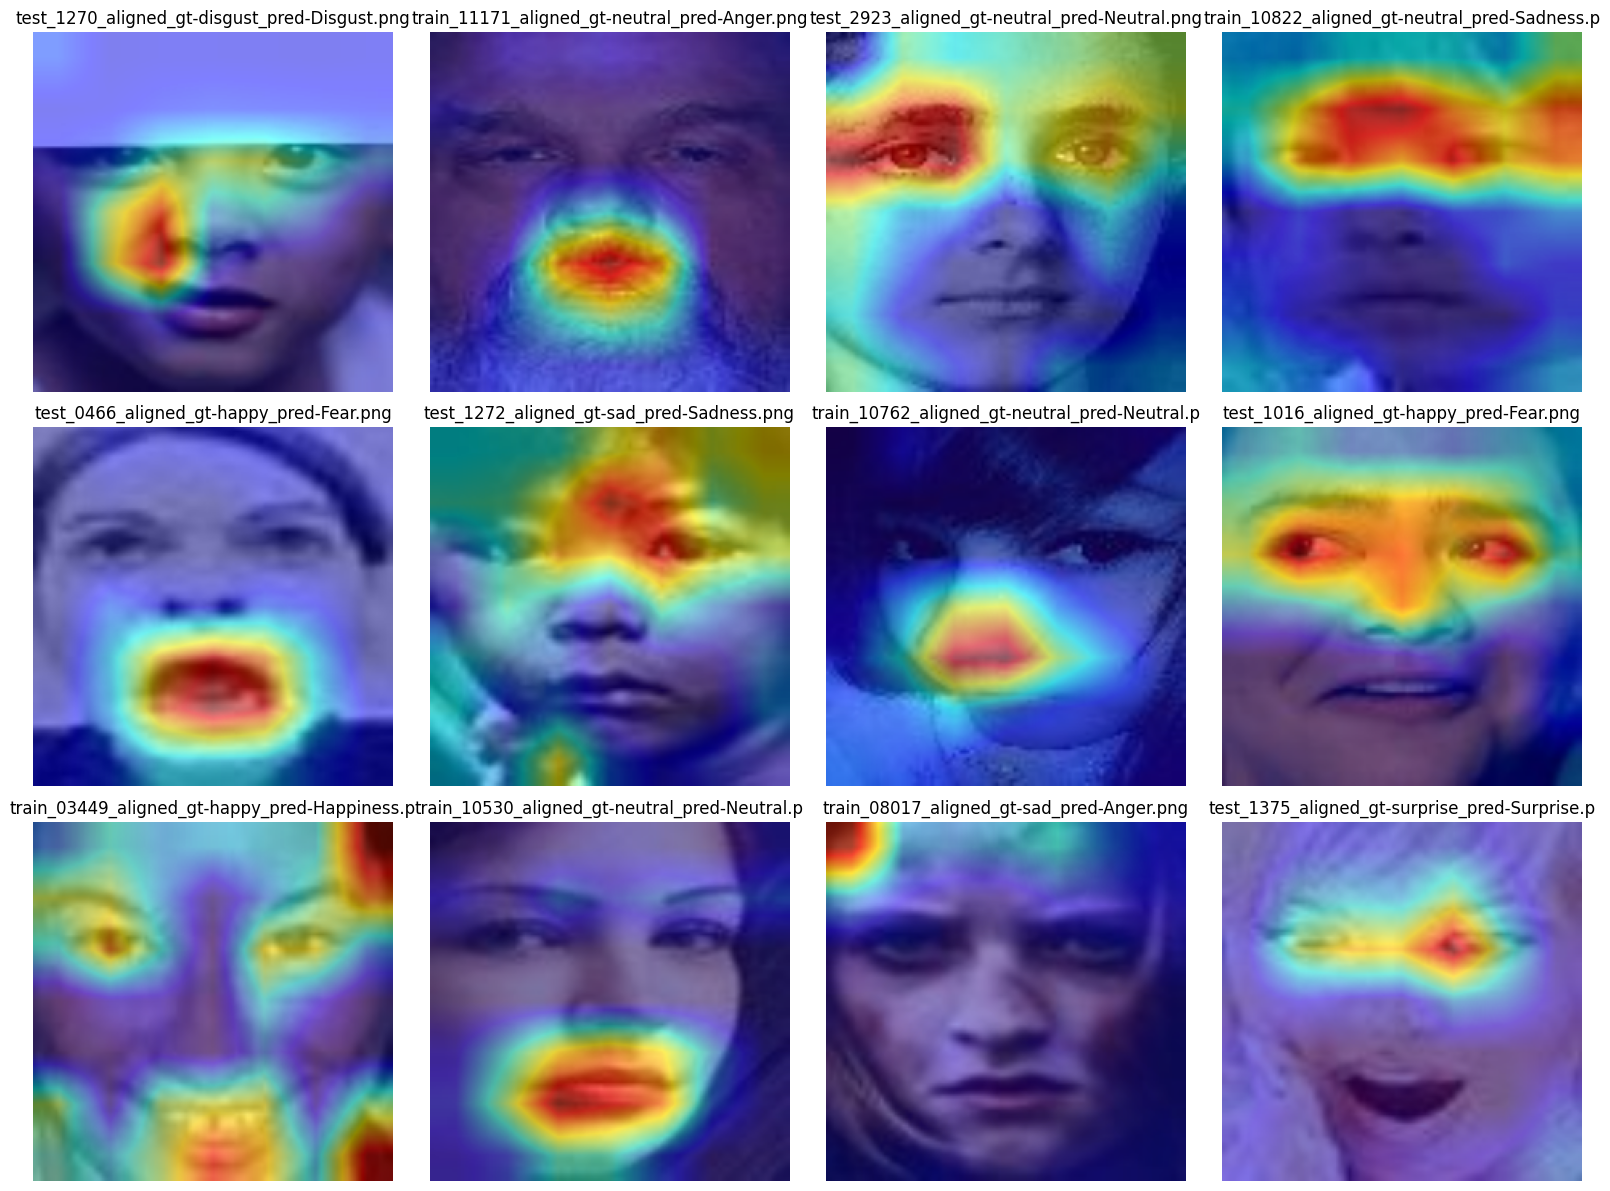

In [92]:
def show_overlay_grid(df_pred, k=12):
    ok = df_pred[df_pred["status"] == "ok"].sample(min(k, (df_pred["status"]=="ok").sum()), random_state=0)
    paths = ok["overlay_path"].tolist()

    cols = 4
    rows = int(np.ceil(len(paths) / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    for j, p in enumerate(paths):
        img = Image.open(p)
        plt.subplot(rows, cols, j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(Path(p).name[:45])

    plt.tight_layout()
    plt.show()

show_overlay_grid(df_pred, k=12)

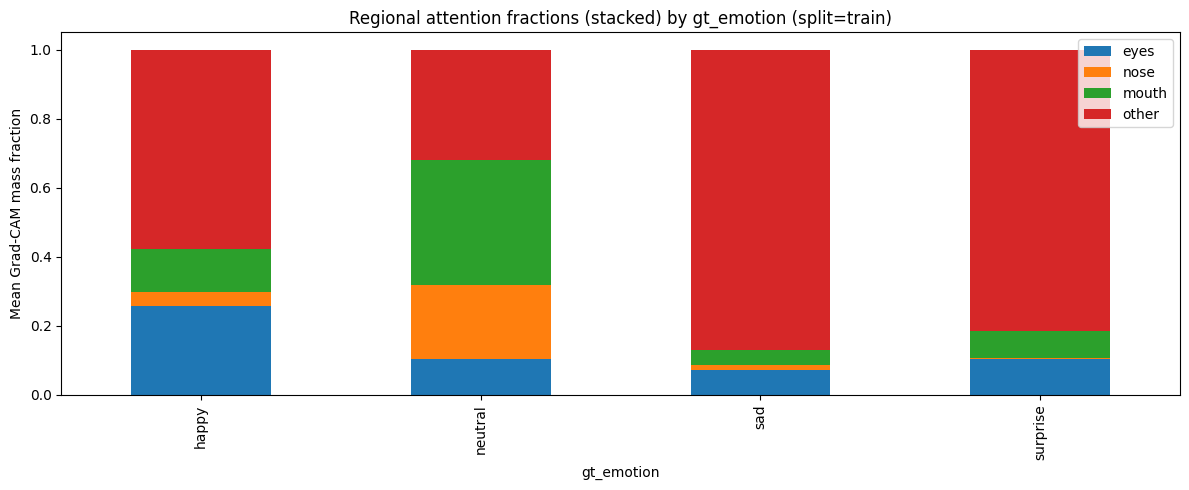

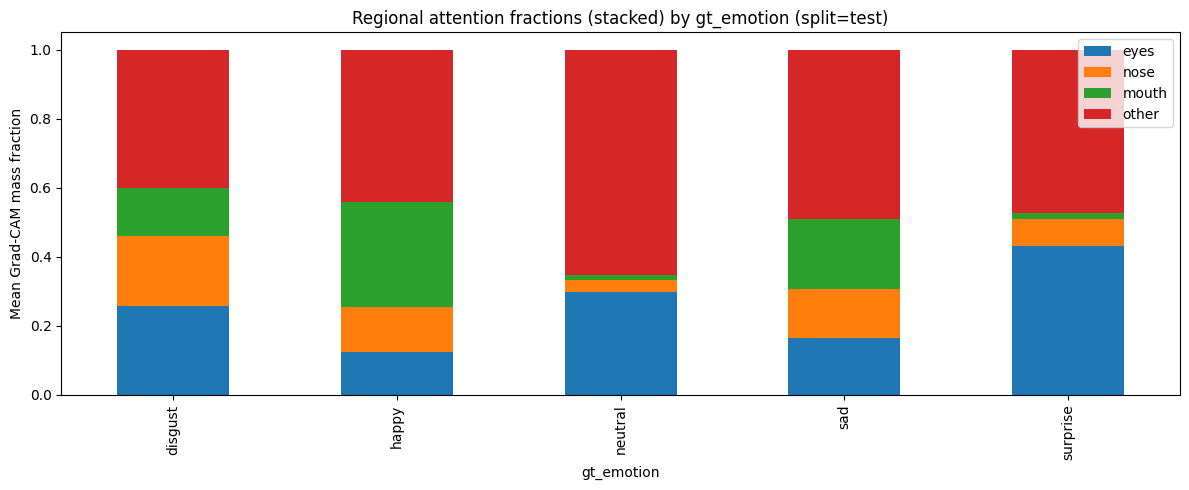

In [93]:
import matplotlib.pyplot as plt

def plot_region_fractions_stacked(df_region, by="gt_emotion", split=None):
    d = df_region.copy()
    if split is not None:
        d = d[d["split"] == split]

    if d.empty:
        print(f"No rows for split={split}. Available: {df_region['split'].value_counts().to_dict()}")
        return

    cols = ["eyes", "nose", "mouth", "other"]
    grp = d.groupby(by)[cols].mean().sort_index()

    grp = grp.div(grp.sum(axis=1).replace(0, 1), axis=0)

    ax = grp.plot(kind="bar", stacked=True, figsize=(12, 5))
    ax.set_ylabel("Mean Grad-CAM mass fraction")
    ax.set_title(f"Regional attention fractions (stacked) by {by}" + (f" (split={split})" if split else ""))
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_region_fractions_stacked(df_region, by="gt_emotion", split="train")
plot_region_fractions_stacked(df_region, by="gt_emotion", split="test")

In [94]:
df_merged["split"].value_counts()
df_merged["gt_emotion"].isna().groupby(df_merged["split"]).mean()

,gt_emotion
split,
test,0.0
train,0.0
